In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

import nltk
from nltk.tokenize import word_tokenize

from wordcloud import WordCloud

In [3]:
ratings_file = 'BX-Ratings.csv'

# load user data file into a dataframe 
ratings = pd.read_csv(ratings_file)

In [4]:
# check data types in the dataframe
ratings.head()
print(ratings.dtypes)

# convert to string to handle potential non-numeric entries
ratings_str = ratings.astype(str)

User-ID         int64
ISBN           object
Book-Rating     int64
dtype: object


In [5]:
# check for missing data

missing_ratings = ratings.isna().sum()
print(missing_ratings)

User-ID        0
ISBN           0
Book-Rating    0
dtype: int64


In [6]:
# use regex string matching to extract numeric entries from user id strings

userid_str = ratings_str["User-ID"]

def filter_userid(userid_str): 
    match = re.search(r'(\d+)', userid_str)
    return int(userid_str) if match else "others"

# apply the filter_column function to the 'User-ID' column in the original dataframe
ratings["User-ID"] = ratings_str["User-ID"].apply(filter_userid)

# check how many "others" - aka invalid entries
print(ratings["User-ID"].value_counts().get("others",0))

0


In [7]:
# Use regex string matching to extract ISBNs with the specified format

ISBN_str = ratings_str['ISBN']

def filter_ISBN(ISBN_str):
    match = re.match(r'^\d{9}[\dX]$', ISBN_str)
    return ISBN_str if match else "others"

# Apply the filter_isbn function to the 'ISBN' column in the original DataFrame
ratings['ISBN'] = ratings_str['ISBN'].apply(filter_ISBN)

# check how many "others" - aka invalid entries
print(ratings['ISBN'].value_counts().get("others",0))

4


In [8]:
# confirm that all entries in the 'Book-Ratings' column are within range and numeric
entries = ratings["Book-Rating"].astype(float).between(1,10, inclusive='both')
if entries.all():
    print ('No invalid entries')

No invalid entries


In [9]:
# since "others" is either a very small amount or non-existent, we can filter out all the entries listed as "others"
ratings = ratings[(ratings != "others").all(axis=1)]

print(ratings)

        User-ID        ISBN  Book-Rating
0        276744  038550120X            7
1        276754  0684867621            8
2        276755  0451166892            5
3        276762  0380711524            5
4        276772  0553572369            7
...         ...         ...          ...
204159   276688  0892966548           10
204160   276688  1551669315            6
204161   276704  0345386108            6
204162   276704  0743211383            7
204163   276709  0515107662           10

[204160 rows x 3 columns]


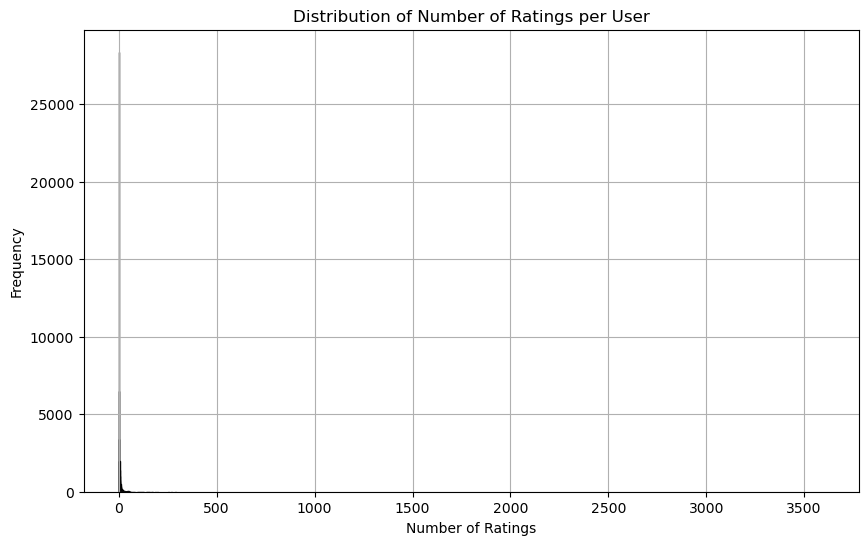

In [10]:
user_ratings_count = ratings.groupby("User-ID").size()

frequency = user_ratings_count.value_counts().sort_index()

plt.figure(figsize=(10, 6))
plt.bar(frequency.index, frequency.values, color='blue', edgecolor='black')
plt.title('Distribution of Number of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


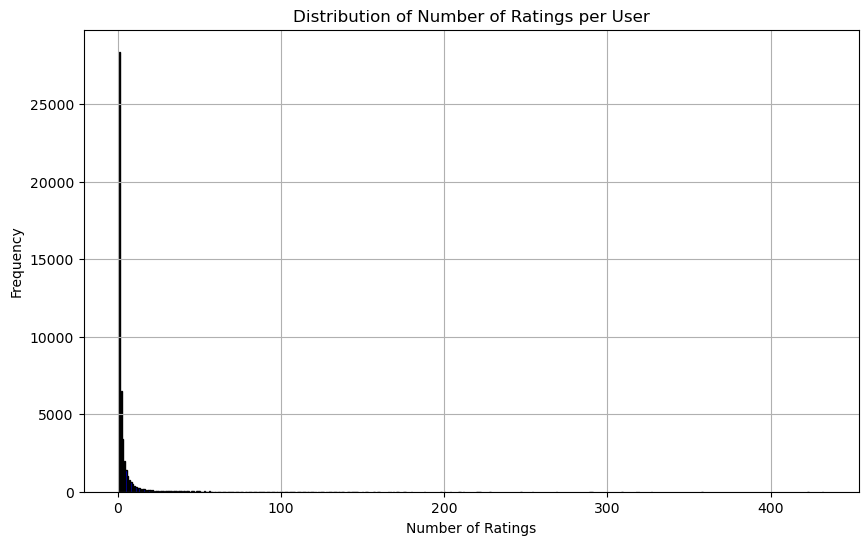

In [11]:
# as can be seen from the above distribution, the range of the number of ratings is way too large so we need to restrict 
# we can see that most of the distribution is before 500 - so let's restrict the range of the number ratings to below 500

user_ratings_count = ratings.groupby("User-ID").size()
user_ids_restricted = user_ratings_count[user_ratings_count<500]

frequency = user_ids_restricted.value_counts().sort_index()

plt.figure(figsize=(10, 6))
plt.bar(frequency.index, frequency.values, color='blue', edgecolor='black')
plt.title('Distribution of Number of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

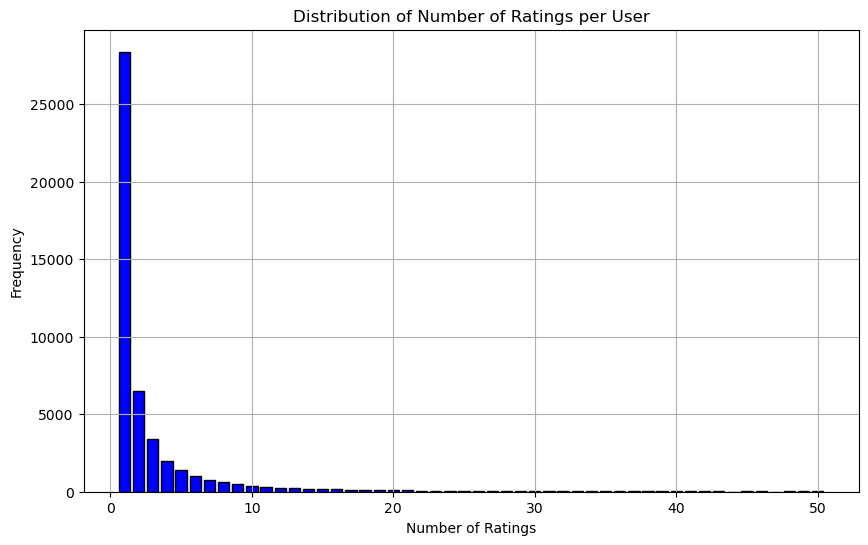

In [12]:
# we can see the restricted range is still not close enough, so let's restrict to below 50 to see where more of the distribution is located

user_ratings_count = ratings.groupby("User-ID").size()
user_ids_restricted = user_ratings_count[user_ratings_count<=50]

frequency = user_ids_restricted.value_counts().sort_index()

plt.figure(figsize=(10, 6))
plt.bar(frequency.index, frequency.values, color='blue', edgecolor='black')
plt.title('Distribution of Number of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

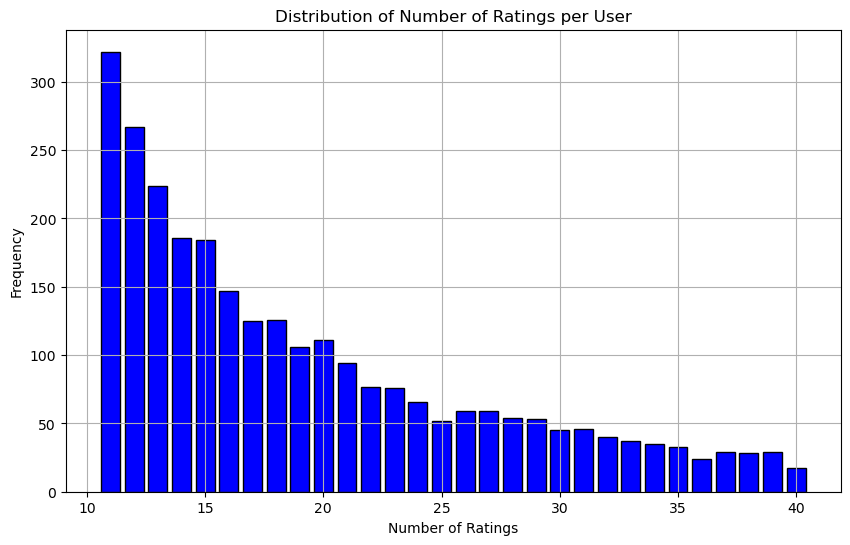

In [13]:
# temporarily restrict rating frequency to see distribution of other smaller numbers more clearly 

# Plotting Category 1: 1 rating
user_ratings_count = ratings.groupby("User-ID").size()
user_ids_restricted = user_ratings_count[(user_ratings_count>=11) & (user_ratings_count<=40)]

frequency = user_ids_restricted.value_counts().sort_index()

plt.figure(figsize=(10, 6))
plt.bar(frequency.index, frequency.values, color='blue', edgecolor='black')
plt.title('Distribution of Number of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

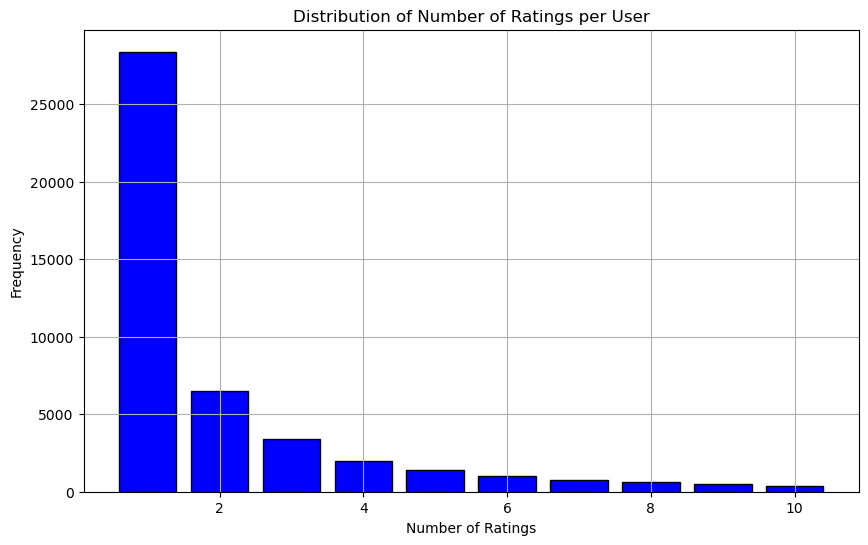

In [14]:
# we restrict to 3 categories - low quality users (1-10 ratings), mid quality users (11-40 ratings), high quality users (above 40 ratings)

# plot low quality users
user_ratings_count = ratings.groupby("User-ID").size()
user_ids_restricted = user_ratings_count[(user_ratings_count>=1)&(user_ratings_count <=10)]

frequency = user_ids_restricted.value_counts().sort_index()

plt.figure(figsize=(10, 6))
plt.bar(frequency.index, frequency.values, color='blue', edgecolor='black')
plt.title('Distribution of Number of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

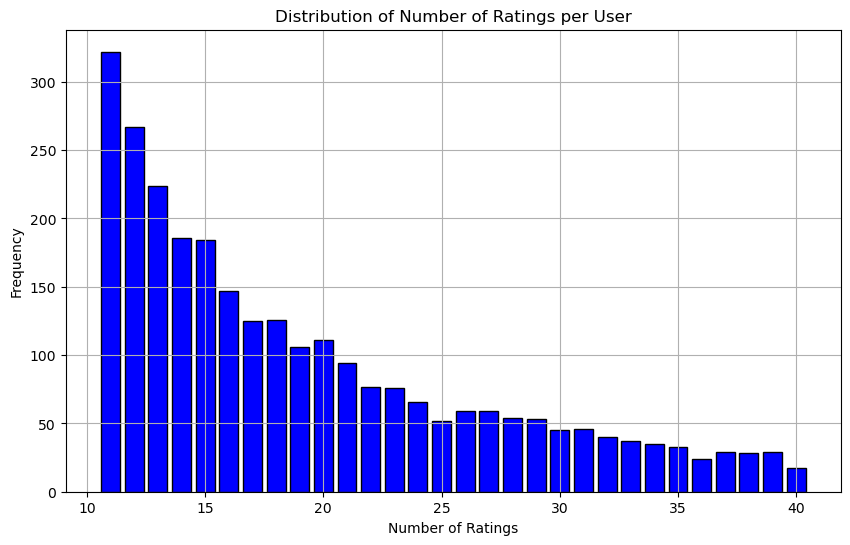

In [15]:
# plot mid quality users 

user_ratings_count = ratings.groupby("User-ID").size()
user_ids_restricted = user_ratings_count[(user_ratings_count>=11)&(user_ratings_count <=40)]

frequency = user_ids_restricted.value_counts().sort_index()

plt.figure(figsize=(10, 6))
plt.bar(frequency.index, frequency.values, color='blue', edgecolor='black')
plt.title('Distribution of Number of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

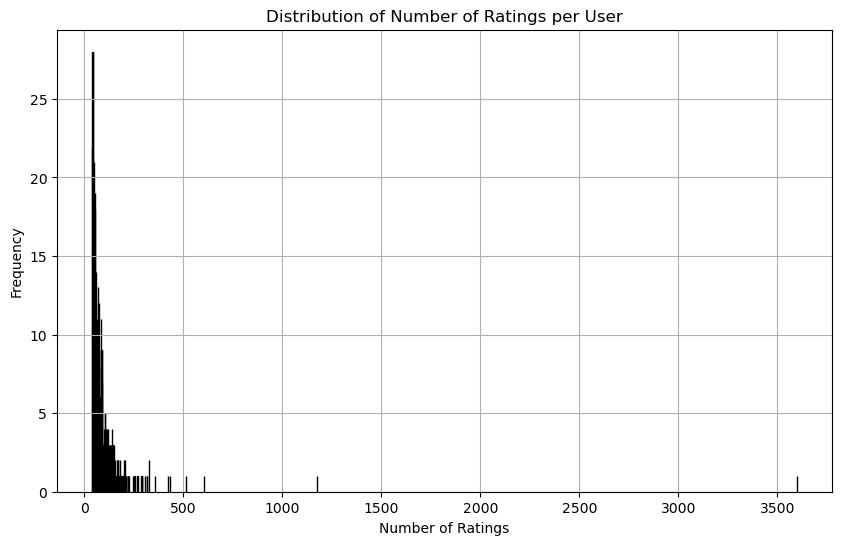

In [16]:
# plot high quality users 

user_ratings_count = ratings.groupby("User-ID").size()
user_ids_restricted = user_ratings_count[(user_ratings_count>40)]

frequency = user_ids_restricted.value_counts().sort_index()

plt.figure(figsize=(10, 6))
plt.bar(frequency.index, frequency.values, color='blue', edgecolor='black')
plt.title('Distribution of Number of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

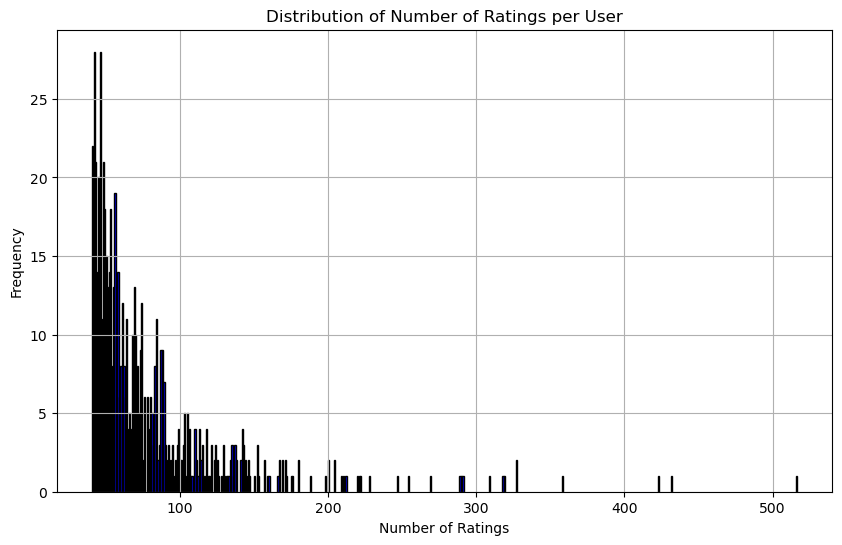

In [17]:
# get rid of anything above 550 - low frequency and they are outliers - could potentially be people trolling

# plot revised version of high quality users 

user_ratings_count = ratings.groupby("User-ID").size()
user_ids_restricted = user_ratings_count[(user_ratings_count> 40)&(user_ratings_count <=550)]

frequency = user_ids_restricted.value_counts().sort_index()

plt.figure(figsize=(10, 6))
plt.bar(frequency.index, frequency.values, color='blue', edgecolor='black')
plt.title('Distribution of Number of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [18]:
# output as 3 different categories of users

# output low quality users
low_quality_users = user_ratings_count[(user_ratings_count<=10)&(user_ratings_count>=1)].index
ratings_lowquality = ratings[ratings["User-ID"].isin(low_quality_users)]

# output mid quality users
mid_quality_users = user_ratings_count[(user_ratings_count<=40)&(user_ratings_count>=11)].index
ratings_midquality = ratings[ratings["User-ID"].isin(mid_quality_users)]

# output high quality users
high_quality_users = user_ratings_count[(user_ratings_count<550)&(user_ratings_count>40)].index
ratings_highquality = ratings[ratings["User-ID"].isin(high_quality_users)]


In [19]:
# check length of data in preparation for processing - in case we need to reduce dimension

filtered_hq_users = user_ratings_count[(user_ratings_count<550)&(user_ratings_count>40)]

# number of users 
print(len(filtered_hq_users))

# total number of ratings from these users 
print(len(ratings_highquality))


686
55153


In [20]:
# merge low quality with cleaned books and cleaned users

books_df = pd.read_csv('cleaned_books.csv')
users_df = pd.read_csv('cleaned_users.csv')

# First merge: Ratings with Books on 'ISBN'
ratings_books_merged = pd.merge(ratings_lowquality, books_df, on='ISBN', how='inner')
# Second merge: Resulting DataFrame with Users on 'User-ID'
final_merged_df = pd.merge(ratings_books_merged, users_df, on='User-ID', how='inner')
# Save the merged DataFrame to a new CSV file
final_merged_df.to_csv('lowquality_final_merged.csv', index=False)



In [21]:
# merge high quality with cleaned books and cleaned users 

# First merge: Ratings with Books on 'ISBN'
ratings_books_merged = pd.merge(ratings_highquality, books_df, on='ISBN', how='inner')
# Second merge: Resulting DataFrame with Users on 'User-ID'
final_merged_df = pd.merge(ratings_books_merged, users_df, on='User-ID', how='inner')
# Save the merged DataFrame to a new CSV file
final_merged_df.to_csv('highquality_final_merged.csv', index=False)

In [22]:
# merge mid quality with cleaned books and cleaned users 

# First merge: Ratings with Books on 'ISBN'
ratings_books_merged = pd.merge(ratings_midquality, books_df, on='ISBN', how='inner')
# Second merge: Resulting DataFrame with Users on 'User-ID'
final_merged_df = pd.merge(ratings_books_merged, users_df, on='User-ID', how='inner')
# Save the merged DataFrame to a new CSV file
final_merged_df.to_csv('midquality_final_merged.csv', index=False)

In [23]:
# merge original data so that we can use as training data

original_books = pd.read_csv('BX-Books.csv')
original_ratings = pd.read_csv('BX-Ratings.csv')
original_users = pd.read_csv('BX-Users.csv')

# First merge: Ratings with Books on 'ISBN'
ratings_books_merged = pd.merge(original_ratings, original_books, on='ISBN', how='inner')
# Second merge: Resulting DataFrame with Users on 'User-ID'
final_merged_df = pd.merge(ratings_books_merged, original_users, on='User-ID', how='inner')
# Save the merged DataFrame to a new CSV file
final_merged_df.to_csv('merge_all_original.csv', index=False)